# Jupyter Notebook to train a model

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tf_explain.callbacks.grad_cam import GradCAMCallback

# use random seed to reproduce results
np.random.seed(42)
tf.random.set_seed(42)

import matplotlib as mpl
import matplotlib.pyplot as plt
import os

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn_metrics"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### lists possible devices (CPU, GPU), used to check if GPU is recognized/exists

In [3]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Methods

### used to save a trained model as a json file and its weights as a h5 file

In [4]:
def save_model(model, model_name, path):
    my_model = model.to_json()
    with open(f'./{path}/{model_name}.json', "w") as file:
        file.write(my_model)
    # serialize weights to HDF5
    model.save_weights(f'./{path}/{model_name}_weights.h5')

### used to build the base model using predefined architectures
currently: vgg16, xception, resnet

In [5]:
def build_base_model(architecture, weights):
    input = tf.keras.Input(shape=(224, 224, 3))
    if architecture == 'vgg16':
        return tf.keras.applications.vgg16.VGG16(weights=weights, include_top=False, input_tensor=input)
    if architecture == 'xception':
        return tf.keras.applications.xception.Xception(weights=weights, include_top=False, input_tensor=input)
    if architecture == 'resnet':
        return tf.keras.applications.resnet.ResNet50(weights=weights, include_top=False, input_tensor=input)

### gets base model as input and builds a new top layer and returns the model with custom top layers

In [6]:
def build_model(base_model):
    flat = keras.layers.Flatten(name='flatten')(base_model.output)
    dense_1 = keras.layers.Dense(1400)(flat)
    dropout = keras.layers.Dropout(0.25)(dense_1)
    batch = keras.layers.BatchNormalization()(dropout)
    output = keras.layers.Dense(1, activation='sigmoid')(batch)
    return tf.keras.Model(base_model.input, output)

### gets a model as input and returns a model compiled with the adam optimizer

In [7]:
def compile_model(model, alpha, beta1, beta2, metrics):
    optimizer = keras.optimizers.Adam(learning_rate=alpha, beta_1=beta1, beta_2=beta2)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)
    return model

### gets a model as input and trains it on the data-set with the defined callbacks and epochs

In [8]:
def train_model(model, train_set, validation_set, epochs, callback):
    return model.fit(train_set,
                     validation_data=validation_set,
                     epochs=epochs,
                     callbacks=callback)

### gets a model as input and changes its layers trainable attribute

In [9]:
def set_layers_trainable(trainable, input_model):
    for layer in input_model.layers:
        layer.trainable = trainable

## Data preprocessing

preprocessing of the images applied when loading image data set from disk with tensorflows flow_from_directory


In [10]:
image_gen = keras.preprocessing.image.ImageDataGenerator(rotation_range=20,  # rotate the image 20 degrees
                                                         width_shift_range=0.2,
                                                         height_shift_range=0.2,
                                                         rescale=1 / 255,  # Rescale the image by normalzing it.
                                                         shear_range=0.15,
                                                         # Shear means cutting away part of the image (max 20%)
                                                         zoom_range=0.15,  # Zoom in by 15% max
                                                         horizontal_flip=True,  # Allow horizontal flipping
                                                         fill_mode='nearest'
                                                         # Fill in missing pixels with the nearest filled value
                                                         )
t_image_gen = keras.preprocessing.image.ImageDataGenerator()

path to the data set

In [11]:
train_data_path = './data/cropped_full/balanced_data/train'  #local notebook
validation_data_path = './data/cropped_full/balanced_data/val'  #local notebook
test_data_path = './data/cropped_full/balanced_data/test'  #local notebook

generate training set by loading the images from their directories with flow_from_directory
important: the folder structure has to match! i.e {train} -> {ok,def}
at the "same time" the data augmentation is applied on the images through the ImageDataGenerator

In [12]:
batch_size = 64
train_image_gen = image_gen.flow_from_directory(train_data_path,
                                                target_size=(224, 224),
                                                batch_size=batch_size,
                                                class_mode='binary')

Found 39840 images belonging to 2 classes.


In [13]:
valid_image_gen = t_image_gen.flow_from_directory(validation_data_path,
                                                target_size=(224, 224),
                                                batch_size=batch_size,
                                                class_mode='binary')

Found 8537 images belonging to 2 classes.


In [14]:
test_image_gen = t_image_gen.flow_from_directory(test_data_path,
                                               target_size=(224, 224),
                                                batch_size=batch_size,
                                               class_mode='binary')

Found 8539 images belonging to 2 classes.


# Training of the model

Epoch 1/5
623/623 [==============================] - 434s 667ms/step - loss: 0.0246 - accuracy: 0.9917 - recall: 0.9895 - precision: 0.9939 - auc: 0.9990 - val_loss: 212.7005 - val_accuracy: 0.6065 - val_recall: 1.0000 - val_precision: 0.5597 - val_auc: 0.6077
Epoch 2/5
623/623 [==============================] - 309s 496ms/step - loss: 0.0017 - accuracy: 0.9995 - recall: 0.9993 - precision: 0.9996 - auc: 0.9999 - val_loss: 1.3637 - val_accuracy: 0.9903 - val_recall: 0.9806 - val_precision: 1.0000 - val_auc: 0.9904
Epoch 3/5
623/623 [==============================] - 316s 507ms/step - loss: 0.0080 - accuracy: 0.9976 - recall: 0.9972 - precision: 0.9980 - auc: 0.9997 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_recall: 1.0000 - val_precision: 1.0000 - val_auc: 1.0000
Epoch 4/5
623/623 [==============================] - 317s 508ms/step - loss: 8.5683e-04 - accuracy: 0.9998 - recall: 0.9997 - precision: 0.9998 - auc: 1.0000 - val_loss: 0.0977 - val_accuracy: 0.9987 - val_recall: 1.0

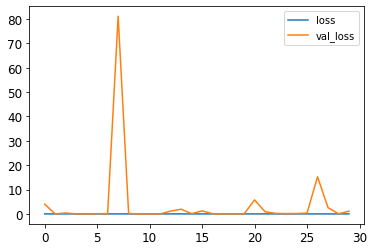

Saving figure vgg16_accuracy


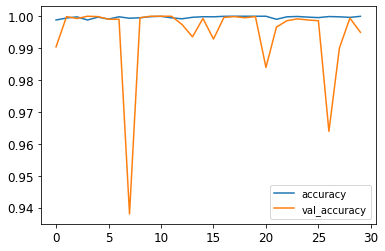

Saving figure vgg16_recall


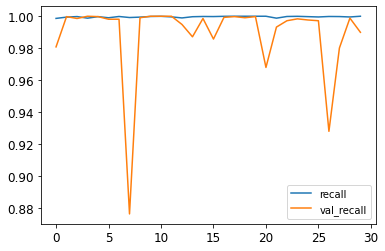

Saving figure vgg16_precision


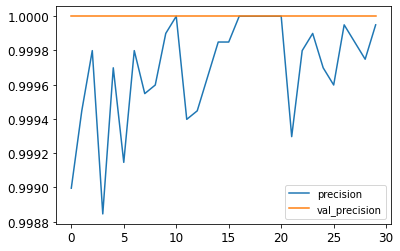

Saving figure vgg16_auc


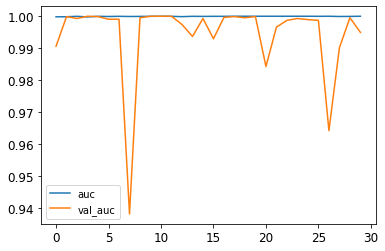

In [15]:
vgg16 = build_base_model('vgg16', 'imagenet')
vgg16_model = build_model(vgg16)
vgg16_model = compile_model(vgg16_model, 0.0001, 0.9, 0.999, ['accuracy', 'Recall', 'Precision', 'AUC'])
set_layers_trainable(False, vgg16)
history = train_model(vgg16_model, train_image_gen, valid_image_gen, 5, [])
set_layers_trainable(True, vgg16)
save_model(vgg16_model, 'vgg16_first_train_step_new_data_cropped', 'saved_models/first_train_step')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs", histogram_freq=5, write_graph=True,
                                                      write_images=True)
custom_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
vgg16_model = compile_model(vgg16_model, 0.0001, 0.9, 0.999, ['accuracy', 'Recall', 'Precision', 'AUC'])
history = train_model(vgg16_model, train_image_gen, valid_image_gen, 100,
                      [custom_early_stopping, tensorboard_callback])
loss, accuracy, recall, precision, auc = vgg16_model.evaluate(test_image_gen)
# F1 score
f1 = 2 * ((precision * recall) / (precision + recall))

print(f"loss: {loss}, \n"
      f"accuracy: {accuracy}, \n"
      f"recall: {recall}, \n"
      f"precision: {precision}, \n"
      f"auc: {auc}, \n"
      f"F1: {f1}")
save_model(vgg16_model, 'vgg16_new_data_cropped', 'saved_models/second_train_step')
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
save_fig('vgg16_loss', tight_layout=False)
plt.show()
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
save_fig('vgg16_accuracy', tight_layout=False)
plt.show()
plt.plot(history.epoch, metrics['recall'], metrics['val_recall'])
plt.legend(['recall', 'val_recall'])
save_fig('vgg16_recall', tight_layout=False)
plt.show()
plt.plot(history.epoch, metrics['precision'], metrics['val_precision'])
plt.legend(['precision', 'val_precision'])
save_fig('vgg16_precision', tight_layout=False)
plt.show()
plt.plot(history.epoch, metrics['auc'], metrics['val_auc'])
plt.legend(['auc', 'val_auc'])
save_fig('vgg16_auc', tight_layout=False)
plt.show()

Epoch 1/5
623/623 [==============================] - 293s 461ms/step - loss: 0.0128 - accuracy: 0.9973 - recall: 0.9974 - precision: 0.9973 - auc: 0.9993 - val_loss: 869.5765 - val_accuracy: 0.5002 - val_recall: 1.0000 - val_precision: 0.5002 - val_auc: 0.5000
Epoch 2/5
623/623 [==============================] - 287s 460ms/step - loss: 1.4312e-04 - accuracy: 0.9999 - recall: 0.9999 - precision: 0.9999 - auc: 1.0000 - val_loss: 9266.2910 - val_accuracy: 0.5002 - val_recall: 1.0000 - val_precision: 0.5002 - val_auc: 0.5000
Epoch 3/5
623/623 [==============================] - 287s 461ms/step - loss: 5.4846e-04 - accuracy: 0.9998 - recall: 0.9998 - precision: 0.9998 - auc: 1.0000 - val_loss: 8774.0293 - val_accuracy: 0.5002 - val_recall: 1.0000 - val_precision: 0.5002 - val_auc: 0.5000
Epoch 4/5
623/623 [==============================] - 289s 463ms/step - loss: 2.5116e-06 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - auc: 1.0000 - val_loss: 8852.9512 - val_accuracy: 0.5002 - va

C:\Users\User\anaconda3\envs\sls-windows\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/100
623/623 [==============================] - 310s 490ms/step - loss: 0.0068 - accuracy: 0.9988 - recall: 0.9988 - precision: 0.9988 - auc: 0.9997 - val_loss: 3602.7788 - val_accuracy: 0.5002 - val_recall: 1.0000 - val_precision: 0.5002 - val_auc: 0.5000
Epoch 2/100
623/623 [==============================] - 292s 468ms/step - loss: 5.4318e-04 - accuracy: 0.9998 - recall: 0.9998 - precision: 0.9998 - auc: 1.0000 - val_loss: 21302.2305 - val_accuracy: 0.5002 - val_recall: 1.0000 - val_precision: 0.5002 - val_auc: 0.5000
Epoch 3/100
623/623 [==============================] - 294s 471ms/step - loss: 3.2054e-05 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - auc: 1.0000 - val_loss: 37960.9922 - val_accuracy: 0.5002 - val_recall: 1.0000 - val_precision: 0.5002 - val_auc: 0.5000
Epoch 4/100
623/623 [==============================] - 295s 472ms/step - loss: 5.0316e-06 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - auc: 1.0000 - val_loss: 42702.0938 - val_accuracy:

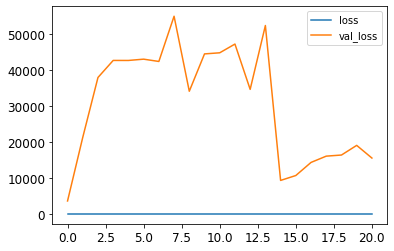

Saving figure resNet_accuracy


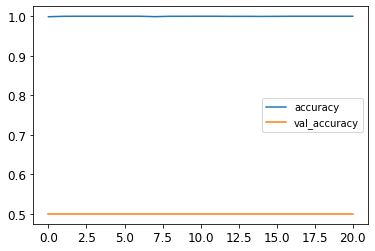

Saving figure resNet_recall


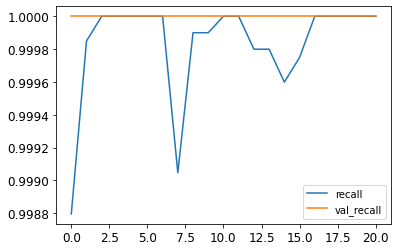

Saving figure resNet_precision


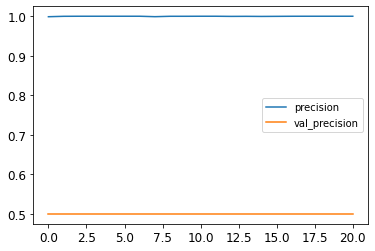

Saving figure resNet_auc


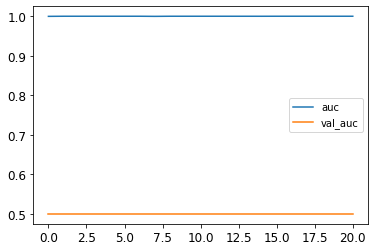

In [16]:
resnet = build_base_model('resnet', 'imagenet')
resnet_model = build_model(resnet)
resnet_model = compile_model(resnet_model, 0.0001, 0.9, 0.999, ['accuracy', 'Recall', 'Precision', 'AUC'])
set_layers_trainable(False, resnet)
res_history = train_model(resnet_model, train_image_gen, valid_image_gen, 5, [])
set_layers_trainable(True, resnet)
save_model(resnet_model, 'resnet_first_train_step_new_data_cropped', 'saved_models/first_train_step')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs", histogram_freq=5, write_graph=True,
                                                      write_images=True)
custom_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
resnet_model = compile_model(resnet_model, 0.0001, 0.9, 0.999, ['accuracy', 'Recall', 'Precision', 'AUC'])
res_history = train_model(resnet_model, train_image_gen, valid_image_gen, 100,
                          [custom_early_stopping, tensorboard_callback])
loss, accuracy, recall, precision, auc = resnet_model.evaluate(test_image_gen)
# F1 score
f1 = 2 * ((precision * recall) / (precision + recall))

print(f"loss: {loss}, \n"
      f"accuracy: {accuracy}, \n"
      f"recall: {recall}, \n"
      f"precision: {precision}, \n"
      f"auc: {auc}, \n"
      f"F1: {f1}")

save_model(resnet_model, 'resnet_new_data_cropped', 'saved_models/second_train_step')
metrics = res_history.history
plt.plot(res_history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
save_fig('restNet_loss', tight_layout=False)
plt.show()
plt.plot(res_history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
save_fig('resNet_accuracy', tight_layout=False)
plt.show()
plt.plot(res_history.epoch, metrics['recall'], metrics['val_recall'])
plt.legend(['recall', 'val_recall'])
save_fig('resNet_recall', tight_layout=False)
plt.show()
plt.plot(res_history.epoch, metrics['precision'], metrics['val_precision'])
plt.legend(['precision', 'val_precision'])
save_fig('resNet_precision', tight_layout=False)
plt.show()
plt.plot(res_history.epoch, metrics['auc'], metrics['val_auc'])
plt.legend(['auc', 'val_auc'])
save_fig('resNet_auc', tight_layout=False)
plt.show()

In [17]:
xception = build_base_model('xception', 'imagenet')
xception_model = build_model(xception)
xception_model = compile_model(xception_model, 0.0001, 0.9, 0.999, ['accuracy', 'Recall', 'Precision', 'AUC'])
set_layers_trainable(False, xception)
xc_history = train_model(xception_model, train_image_gen, valid_image_gen, 5, [])
set_layers_trainable(True, xception)
save_model(xception_model, 'xception_first_train_step_new_data', 'saved_models/first_train_step')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs", histogram_freq=5, write_graph=True,
                                                      write_images=True)
custom_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
xception_model = compile_model(xception_model, 0.0001, 0.9, 0.999, ['accuracy', 'Recall', 'Precision', 'AUC'])
xc_history = train_model(xception_model, train_image_gen, valid_image_gen, 100,
                         [custom_early_stopping, tensorboard_callback])
loss, accuracy, recall, precision, auc = xception_model.evaluate(test_image_gen)
# F1 score
f1 = 2 * ((precision * recall) / (precision + recall))

print(f"loss: {loss}, \n"
      f"accuracy: {accuracy}, \n"
      f"recall: {recall}, \n"
      f"precision: {precision}, \n"
      f"auc: {auc}, \n"
      f"F1: {f1}")
save_model(xception_model, 'xception_new_data', 'saved_models/second_train_step')
tf.config.get_visible_devices()
metrics = xc_history.history
plt.plot(xc_history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
save_fig('xception_loss', tight_layout=False)
plt.show()
plt.plot(xc_history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
save_fig('xception_accuracy', tight_layout=False)
plt.show()
plt.plot(xc_history.epoch, metrics['recall'], metrics['val_recall'])
plt.legend(['recall', 'val_recall'])
save_fig('xception_recall', tight_layout=False)
plt.show()
plt.plot(xc_history.epoch, metrics['precision'], metrics['val_precision'])
plt.legend(['precision', 'val_precision'])
save_fig('xception_precision', tight_layout=False)
plt.show()
plt.plot(xc_history.epoch, metrics['auc'], metrics['val_auc'])
plt.legend(['auc', 'val_auc'])
save_fig('xception_auc', tight_layout=False)
plt.show()

Epoch 1/5


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[64,728,14,14] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_2/block9_sepconv2/separable_conv2d/depthwise (defined at \AppData\Local\Temp/ipykernel_32604/663974549.py:2) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[assert_less_equal_1/Assert/AssertGuard/pivot_f/_41/_89]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[64,728,14,14] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_2/block9_sepconv2/separable_conv2d/depthwise (defined at \AppData\Local\Temp/ipykernel_32604/663974549.py:2) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_214641]

Function call stack:
train_function -> train_function
